In [5]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

%matplotlib inline

In [54]:
marathon_download = pd.read_csv('https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2014/results.csv')

In [18]:
pd.set_option("display.max_columns",None)
marathon_download.head()


,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,35k,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,71.40,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,116.37,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,67.42,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,116.37,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,67.83,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [55]:
marathon_download[['10k','25k','35k','30k','5k','20k','40k','half']] = marathon_download[['10k','25k','35k','30k','5k','20k','40k','half']].apply(pd.to_numeric,errors='coerce')

In [56]:
marathon = marathon_download.copy()

In [16]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

newdf = marathon.select_dtypes(include=numerics)

In [20]:
numeric_df.head()

,10k,division,25k,age,official,genderdiv,35k,overall,pace,30k,5k,20k,40k
0,17.37,8,47.67,47,85.25,8,71.40,8,3.27,59.18,8.02,37.65,80.43
1,32.58,1,82.43,33,138.95,1,116.37,21,5.30,99.33,16.22,65.83,132.10
2,16.62,1,45.80,41,80.60,1,67.42,1,3.08,56.45,7.75,36.10,76.10
3,32.57,3,82.43,24,140.58,3,116.37,27,5.37,99.33,16.20,65.83,132.95
4,17.12,2,46.37,40,81.23,2,67.83,2,3.10,57.03,8.02,36.58,76.72


In [23]:
print(max(numeric_df.age),min(numeric_df.age))


81 18


In [57]:
marathon = marathon_download.copy()
marathon['age_range'] = np.where(marathon.age <=35, 0, np.where(((marathon.age >35)&(marathon.age <=50)), 1, 
                                                                np.where(((marathon.age >50)&(marathon.age <=65)), 2, 
                                                                         np.where(marathon.age >65, 3, np.nan))))

In [58]:
marathon

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,35k,overall,pace,state,30k,5k,half,20k,country,city,40k,age_range
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,71.40,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43,1.0
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,116.37,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10,0.0
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,67.42,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10,1.0
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,116.37,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95,0.0
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,67.83,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72,1.0
5,32.58,"Sumgong, Jemima Jelagat",4,82.45,F,29,140.68,F3,4,NaN,116.37,28,5.37,NaN,99.33,16.22,69.47,65.83,KEN,Nandi,132.95,0.0
6,17.65,"Hug, Marcel E.",4,47.67,M,28,84.65,W4,4,NaN,70.23,4,3.23,NaN,58.60,8.38,39.72,37.65,SUI,Neuenkirch,79.83,0.0
7,30.48,"Geneti, Markos",5,76.95,M,29,129.83,5,5,NaN,107.47,5,4.97,NaN,92.52,15.17,64.85,61.62,ETH,Addis Ababa,122.80,0.0
8,17.12,"Soejima, Masazumi",3,46.37,M,43,81.23,W6,3,NaN,67.83,3,3.10,NaN,57.03,8.00,38.60,36.60,JPN,Isahaya,76.70,1.0
9,30.48,"Hall, Ryan",20,77.68,M,31,137.83,6,20,NaN,112.27,20,5.27,CA,94.78,15.15,65.23,61.78,USA,Redding,129.83,0.0


In [59]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

newdf = marathon.select_dtypes(include=numerics)

newdf.head()

,10k,division,25k,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k,age_range
0,17.37,8,47.67,47,85.25,8,71.40,8,3.27,59.18,8.02,39.72,37.65,80.43,1.0
1,32.58,1,82.43,33,138.95,1,116.37,21,5.30,99.33,16.22,69.47,65.83,132.10,0.0
2,16.62,1,45.80,41,80.60,1,67.42,1,3.08,56.45,7.75,38.03,36.10,76.10,1.0
3,32.57,3,82.43,24,140.58,3,116.37,27,5.37,99.33,16.20,69.47,65.83,132.95,0.0
4,17.12,2,46.37,40,81.23,2,67.83,2,3.10,57.03,8.02,38.60,36.58,76.72,1.0


In [51]:
print(max(marathon.official),min(marathon.official))

538.88 80.6


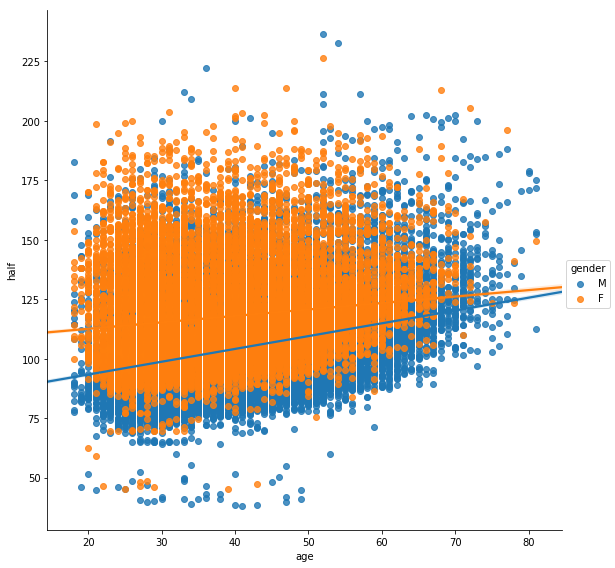

In [74]:
sns.lmplot(x="age", y="half", hue="gender", data=marathon, size=8)

In [150]:
marathon2 = marathon_download.copy()

marathon2['placement_range'] = np.where(marathon2.overall < 10000, 0, 
                                        np.where(((marathon2.overall >=10000)&(marathon2.overall <20000)), 1, 
                                                 np.where(marathon2.overall >= 20000, 2, np.nan)))

In [151]:
marathon2.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,35k,overall,pace,state,30k,5k,half,20k,country,city,40k,placement_range
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,71.40,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43,0.0
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,116.37,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10,0.0
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,67.42,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10,0.0
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,116.37,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95,0.0
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,67.83,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72,0.0


In [152]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

newdf = marathon2.select_dtypes(include=numerics)

# print(newdf.head())

newdf = newdf.dropna()

In [153]:
newdf.head()

,10k,division,25k,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k,placement_range
0,17.37,8,47.67,47,85.25,8,71.40,8,3.27,59.18,8.02,39.72,37.65,80.43,0.0
1,32.58,1,82.43,33,138.95,1,116.37,21,5.30,99.33,16.22,69.47,65.83,132.10,0.0
2,16.62,1,45.80,41,80.60,1,67.42,1,3.08,56.45,7.75,38.03,36.10,76.10,0.0
3,32.57,3,82.43,24,140.58,3,116.37,27,5.37,99.33,16.20,69.47,65.83,132.95,0.0
4,17.12,2,46.37,40,81.23,2,67.83,2,3.10,57.03,8.02,38.60,36.58,76.72,0.0


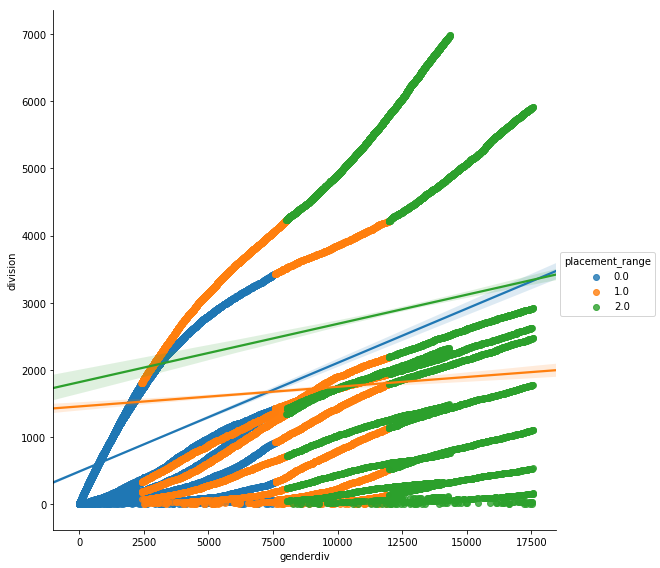

In [154]:
sns.lmplot(x="genderdiv", y="division", hue="placement_range", data=newdf, size=8)

In [155]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

newdf = marathon2.select_dtypes(include=numerics)

# print(newdf.head())

newdf = newdf.dropna()

y = newdf.loc[:,'placement_range']

X = newdf.drop(['placement_range', 'overall','division','genderdiv'],axis=1)

# newdf = newdf.loc[:,['pace','official']]

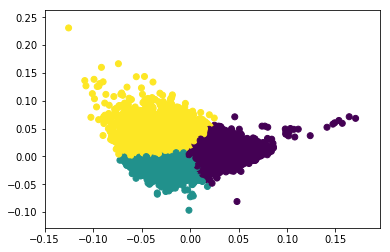

Comparing k-means clusters against the data:
placement_range   0.0   1.0   2.0
row_0                            
0                6659  5757  2377
1                2998  3153  5014
2                 363  1044  4284


In [156]:
# Normalize the data.
X_norm = normalize(X)

# Reduce it to two components.
X_pca = PCA(2).fit_transform(X_norm)

# Calculate predicted values.
y_pred = KMeans(n_clusters=3, random_state=42).fit_predict(X_pca)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))

In [157]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_pca,
    y,
    test_size=0.9,
    random_state=42)

In [158]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_train, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 4


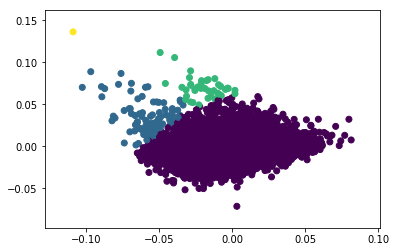

Comparing the assigned categories to the ones in the data:
col_0               0   1   2  3
placement_range                 
0.0               972   3   0  0
1.0               958   9   6  0
2.0              1103  79  33  1


In [159]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=labels)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train,labels))

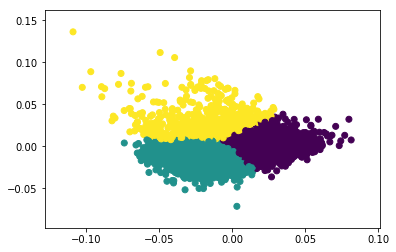

Comparing the assigned categories to the ones in the data:
col_0              0    1    2
placement_range               
0.0              608  326   41
1.0              512  322  139
2.0              219  563  434


In [160]:
from sklearn.cluster import SpectralClustering

# We know we're looking for three clusters.
n_clusters=3

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters)
sc.fit(X_train)

#Predicted clusters.
predict=sc.fit_predict(X_train)

#Graph results.
plt.scatter(X_train[:, 0], X_train[:, 1], c=predict)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train,predict))

In [161]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

# Declare the model and fit it in one statement.
# Note that you can provide arguments to the model, but we didn't.
af = AffinityPropagation().fit(X_train)
print('Done')

# Pull the number of clusters and cluster assignments for each data point.
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_

print('Estimated number of clusters: {}'.format(n_clusters_))


Done
Estimated number of clusters: 190


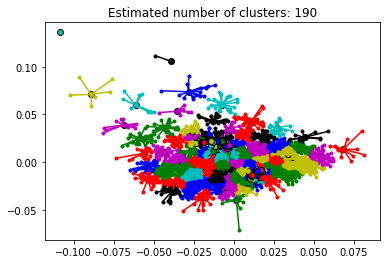

In [162]:
from itertools import cycle

plt.figure(1)
plt.clf()

# Cycle through each cluster and graph them with a center point for the
# exemplar and lines from the exemplar to each data point in the cluster.
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X_train[cluster_centers_indices[k]]
    plt.plot(X_train[class_members, 0], X_train[class_members, 1], col + '.')
    plt.plot(cluster_center[0],
             cluster_center[1],
             'o',
             markerfacecolor=col,
             markeredgecolor='k')
    for x in X_train[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: {}'.format(n_clusters_))
plt.show()